In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

In [4]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [5]:
def plot_video(videodata):
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,videodata.shape[0]-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(videodata[int(i),:,:,0:3])
    plt.show()

In [6]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [7]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [8]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [9]:
def safe_mkdir_subdirs(fn):
    fn_split = fn.split('/')
    n = len(fn.split('/'))
    paths = ['/'.join(fn_split[0:i]) for i in range(0,n) if len('/'.join(fn_split[0:i]))>1]
    for path in paths:
        safe_mkdir(path)

In [10]:
indir = './Data/haa500_v1_1/video'
folders = [f for f in os.listdir(indir) if not f.startswith('.')]
folders.sort()
n = len(folders)
print(n)
print(folders[0:3])
print(folders[n-3::])

500
['ALS_IceBucket_Challenge', 'CPR', 'abseiling']
['yoga_tree', 'yoga_triangle', 'yoga_updog']


In [11]:
fn_temp = indir+'/{folder}/{folder}_{video}.mp4'

In [78]:
# # Get video sizes
# video_sizes = np.zeros((500,20,2))
# for f in tqdm(range(500)):
#     for v in range(20):
#         fn = fn_temp.format(folder=folders[f],video=f'{v:03d}')
#         metadata = skvideo.io.ffprobe(fn)
#         video_sizes[f,v,:] = int(metadata['video']['@height']),int(metadata['video']['@width'])
# np.save('videosizes.npy',np.array(video_sizes))

In [79]:
# video_sizes = np.load('videosizes.npy')

In [80]:
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1);plt.hist(video_sizes[:,:,0].flatten());
# plt.subplot(1,2,2);plt.hist(video_sizes[:,:,1].flatten());

In [81]:
# check = (video_sizes[:,:,0]==720)*(video_sizes[:,:,1]==1280)
# check = check.transpose()
# plt.figure(figsize=(20,5))
# plt.imshow(check)

In [82]:
# np.array((int(np.median(video_sizes[:,:,0].flatten())),int(np.median(video_sizes[:,:,1].flatten()))))

In [83]:
# u,c = np.unique([str(val) for val in video_sizes.reshape(-1,2)],return_counts=True)
# s = np.argsort(c)[-1::-1]
# for i in range(25):
#     print(f'Count: {c[s[i]]}, resolution: {u[s[i]]}')

In [84]:
# f = 1
# v = 0
# fn = fn_temp.format(folder=folders[f],video=f'{v:03d}')
# video_data = load_video(fn)
# print(video_data.shape)

# plot_video(video_data)

In [85]:
# input_size = np.array((720,720))
# input_size = np.array((720,1280))
# input_size = np.array((360,480))
# input_size = np.array((272,480))

In [86]:
# video_data = (np.ones((10,272,480,3))*125).astype(np.uint8)
# plot_video(video_data)

In [12]:
def resize_and_pad_video(video_data):

    target_size = np.array((360, 640))
    input_size = (video_data.shape[1],video_data.shape[2])
    
    d1 = input_size[0]/target_size[0]
    d2 = input_size[1]/target_size[1]

    choose_size = input_size/max(d1,d2)
    choose_size = choose_size.round().astype(int) ## Hacks?

    video_data_resized = np.array([np.array(Image.fromarray(video_data[frame,:,:,:]).resize(choose_size.astype(int)[-1::-1])) for frame in range(video_data.shape[0])])

    assert any(video_data_resized.shape[1:3]==target_size),'neither dimension matches'

    if not video_data_resized.shape[1]==target_size[0]:

        if np.mod(video_data_resized.shape[1],2)==0:
            p = (target_size[0]-video_data_resized.shape[1])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[0]-video_data_resized.shape[1])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(pp[0],pp[1]),(0,0),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(pp[0],pp[1]),(0,0),(0,0)))[0,:,:,0]

    elif not video_data_resized.shape[2]==target_size[1]:

        if np.mod(video_data_resized.shape[2],2)==0:
            p = (target_size[1]-video_data_resized.shape[2])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[1]-video_data_resized.shape[2])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(0,0),(pp[0],pp[1]),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(0,0),(pp[0],pp[1]),(0,0)))[0,:,:,0]

    else:
        video_data_resized_padded = video_data_resized
        padding = np.ones(video_data_resized.shape)[0,:,:,0]

    assert all(video_data_resized_padded.shape[1:3]==target_size), 'failed resizing'
    
    return video_data_resized_padded,padding

In [88]:
f = 0

In [ ]:
for v in range(20):

    fn = fn_temp.format(folder=folders[f],video=f'{v:03d}')
    ofn = fn.replace('haa500_v1_1','haa500_v1_1_resized')

    if not os.path.exists(ofn):
        video_data = load_video(fn)

        video_data_resized_padded,padding = resize_and_pad_video(video_data)


        safe_mkdir_subdirs(ofn)

        save_video(video_data_resized_padded,ofn)
        np.save(ofn.replace('.mp4','_padding.npy'),padding)

        assert load_video(ofn).shape[0]==video_data.shape[0], 'frames mismatch'

In [29]:
arr_exists = np.zeros((20,500))

for f in range(500):
    for v in range(20):

        fn = fn_temp.format(folder=folders[f],video=f'{v:03d}')
        ofn = fn.replace('haa500_v1_1','haa500_v1_1_resized')

        arr_exists[v,f] = os.path.exists(ofn)

Text(0.5, 1.0, 'resized videos')

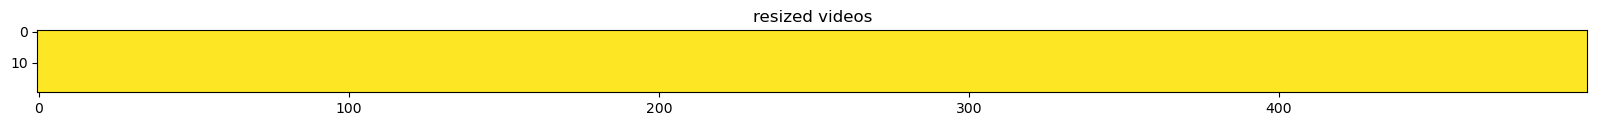

In [36]:
plt.figure(figsize=(20,5))
plt.imshow(arr_exists,vmin=0,vmax=1)
plt.title('resized videos')

In [34]:
arr_exists.mean()

1.0

In [35]:
np.nonzero(arr_exists.sum(axis=0)<20)

(array([], dtype=int64),)

In [89]:
# for f in tqdm(range(500)):
#     for v in range(20):
        
#         fn = fn_temp.format(folder=folders[f],video=f'{v:03d}')
#         ofn = fn.replace('haa500_v1_1','haa500_v1_1_resized')
        
#         if not os.path.exists(ofn):
#             video_data = load_video(fn)

#             video_data_resized_padded,padding = resize_and_pad_video(video_data)


#             safe_mkdir_subdirs(ofn)

#             save_video(video_data_resized_padded,ofn)
#             np.save(ofn.replace('.mp4','_padding.npy'),padding)

#             #assert load_video(ofn).shape[0]==video_data.shape[0], 'frames mismatch'